# Bayesian Exploration with Xopt

## Quality aware test function

Objectives:
- y1: $y_1(x_1,x_2) = (x_1 - 0.5)^2$
- q1: $q_1(x_1,x_2) = \sin(x_1 + x_2)$

In [1]:
# Import the class
from xopt import Xopt

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')

In [2]:
# To see log messages
from xopt import output_notebook
output_notebook()

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
import yaml
# Make a proper input file. 
YAML="""
xopt: {output_path: null}

algorithm:
  name: quality_aware_exploration
  options:  
      n_initial_samples: 3
      n_steps: 20
      target_observation: y1
      quality_observation: q1
      nominal_quality_parameters:
        x2: 0.5
  
evaluate:
  name: test_TNK
  function: xopt.tests.test_functions.quality_aware.evaluate
  
vocs:
  name: TNK_test
  variables:
    x1: [0, 1.0]
    x2: [0, 1.0]
  objectives:
    y1: None
    q1: MAXIMIZE

  constraints: {}
  linked_variables: {}
  constants: {}

"""
config = yaml.safe_load(YAML)

if SMOKE_TEST:
    config['algorithm']['options']['n_steps'] = 3
    config['algorithm']['options']['generator_options']['num_restarts'] = 2
    config['algorithm']['options']['generator_options']['raw_samples'] = 2

In [4]:
X = Xopt(config)
X

Loading config from dict.
`name` keyword no longer allowed in vocs config, removing
Loading config from dict.
Loading config from dict.
Loading config from dict.
Loading config from dict.



            Xopt 
________________________________           
Version: 0.5.0+19.g7d888a1.dirty
Configured: True
Config as YAML:
xopt: {output_path: null}
algorithm:
  name: quality_aware_exploration
  options:
    n_initial_samples: 3
    n_steps: 20
    target_observation: y1
    quality_observation: q1
    nominal_quality_parameters: {x2: 0.5}
    output_path: .
    restart_file: null
    beta: 2.0
  type: batched
  function: null
evaluate:
  name: test_TNK
  function: xopt.tests.test_functions.quality_aware.evaluate
  executor: null
  options: {extra_option: abc}
vocs:
  variables:
    x1: [0, 1.0]
    x2: [0, 1.0]
  objectives: {y1: None, q1: MINIMIZE}
  constraints: {}
  linked_variables: {}
  constants: {}

# Run BayesOpt

In [5]:
# Pick one of these
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor

executor = PoolExecutor()
# This will also work. 
#executor=None

In [6]:
# Change max generations
results = X.run()

Starting at time 2021-10-26T13:39:11-05:00
Generating and submitting initial samples
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results
generating samples
collecting results


# Plotting
- plot input space samples -> yellow points satisfy constraints and purple points do not

C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_12348/629052302.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pts = np.vstack((ele.ravel() for ele in xx)).T
C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_12348/629052302.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[idx].pcolor(*xx, outputs[name].reshape(n,n), vmin=0, vmax=1)


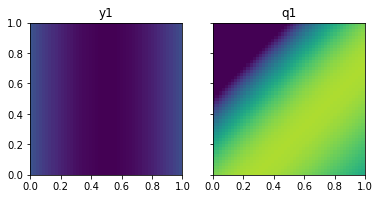

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from xopt.tests.test_functions.quality_aware import VOCS, evaluate
# plot objective functions
n = 50
x = np.linspace(0,1,n)
xx = np.meshgrid(x,x)
pts = np.vstack((ele.ravel() for ele in xx)).T

inputs = {'x1': pts.T[0], 'x2': pts.T[1]}
outputs = evaluate(inputs)
fig, ax = plt.subplots(1,2,sharex='all',sharey='all')

for idx, name in enumerate(outputs.keys()):
    ax[idx].pcolor(*xx, outputs[name].reshape(n,n), vmin=0, vmax=1)
    ax[idx].set_title(name)
    ax[idx].set_aspect('equal')


C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_12348/2278687899.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[idx].pcolor(*xx, mean[idx].reshape(n,n))
C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_12348/2278687899.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[idx].pcolor(*xx, mean[idx].reshape(n,n))


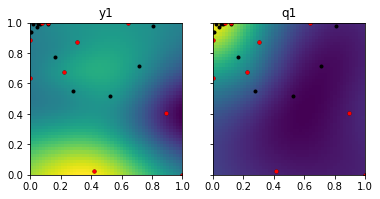

In [8]:
# plot model prediction -> note that model values are inverted for y1 since we minimize
model = X.algorithm.generator.create_model(X.algorithm.data)

tpts = torch.tensor(pts).double()
with torch.no_grad():
    post = model(tpts)
    mean = post.mean

fig, ax = plt.subplots(1,2,sharex='all',sharey='all')
for idx, name in enumerate(outputs.keys()):
    c = ax[idx].pcolor(*xx, mean[idx].reshape(n,n))
    ax[idx].plot(results['x1'], results['x2'], '.', c='black')
    ax[idx].plot(results['x1'][:10], results['x2'][:10], '.', c='red')

    ax[idx].set_title(name)
    ax[idx].set_aspect('equal')

In [9]:
model.covar_module.base_kernel.lengthscale

tensor([[[0.6224, 0.4096]],

        [[0.4903, 0.5160]]], dtype=torch.float64, grad_fn=<SoftplusBackward>)